In [1]:
import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [2]:
data_path = pathlib.Path('../data/').resolve().absolute()
data_path

PosixPath('/mnt/ceph/users/apricewhelan/projects/gd1-dr3/data')

## First, Prepare the data and do query on MAST

https://mastweb.stsci.edu/mcasjobs/MyDB.aspx

Have to split into smaller files to import...

In [3]:
tbl = at.Table.read(data_path / 'gd1-dr3-polygon.fits')
tbl = tbl[tbl['gd1_phi1'] > -100]
len(tbl)

8329047

In [5]:
sub_tbl = tbl['source_id', 'ra', 'dec']
path = data_path / 'tmp'
path.mkdir(exist_ok=True)

idx = np.linspace(0, len(tbl), 4).astype(int)
for j, (i1, i2) in enumerate(zip(idx[:-1], idx[1:])):
    sub_tbl[i1:i2].write(
        path / f'gd1_all_mast_upload{j}.csv', 
        overwrite=True,
        format='ascii.csv'
    )

The query to cross-match with PS1 DR2 (3 arcsecond positional crossmatch):

```
select s.source_id, s.ra, s.dec, o.objID, o.raMean, o.decMean,
   o.nDetections, o.ng, o.nr, o.ni, o.nz, o.ny,
   m.gMeanPSFMag, m.rMeanPSFMag, m.iMeanPSFMag, m.zMeanPSFMag, m.yMeanPSFMag,
   m.gMeanPSFMagErr, m.rMeanPSFMagErr, m.iMeanPSFMagErr, m.zMeanPSFMagErr, m.yMeanPSFMagErr
into mydb.GD1_DR3_xm 
from MyDB.GD1_DR3 s
cross apply fGetNearbyObjEq(s.ra, s.dec, 3.0 / 60.0) nb
inner join ObjectThin o on o.objid=nb.objid and o.nDetections>3
inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid
```

Results saved in `data/tmp/GD1_DR3_xm_pricewhelan.fit`

---

## Join results with Gaia data

Query results:

In [6]:
ps1 = at.Table.read(data_path / 'tmp/GD1_DR3_xm_pricewhelan.fit')
for col in ps1.colnames:
    ps1[col] = ps1[col][:, 0]

In [7]:
len(tbl), len(ps1)

(8329047, 8759198)

In [8]:
joined = at.join(
    tbl, 
    ps1, 
    keys='source_id', 
    uniq_col_name='{col_name}{table_name}', 
    table_names=['', '_2']
)
joined['index'] = np.arange(len(joined), dtype=int)

In [9]:
np.unique(ps1['source_id']).size, np.unique(ps1['objID']).size

(8311136, 8570331)

In [10]:
gaia_c = coord.SkyCoord(joined['ra'], joined['dec'], unit='deg')
ps1_c = coord.SkyCoord(joined['raMean'], joined['decMean'], unit='deg')
sep = gaia_c.separation(ps1_c)
joined['sep_arcsec'] = sep.to_value(u.arcsec)
sep_mask = (
    (sep < 1*u.arcsec) &  # seems I can be stricter
    (joined['ng'] > 2) &  # helps trim PS1 duplicate sources
    (joined['nr'] > 2) & 
    (joined['ni'] > 2)
)

In [11]:
vals, counts = np.unique(joined['source_id'][sep_mask], return_counts=True)
dup_mask = np.isin(joined['source_id'], vals[counts > 1])
dup_mask.sum()

14135

This is a really dumb way to do this but astropy table group_by won't do what I want:

In [12]:
tmp = joined[dup_mask]
del_index = []
for source_id in tqdm(np.unique(tmp['source_id'])):
    rows = tmp[tmp['source_id'] == source_id]
    closest_i = rows['sep_arcsec'].argmin()
    shit = np.asarray(rows['index'][rows['index'] != rows['index'][closest_i]])
    del_index = np.concatenate((del_index, shit))

100%|██████████| 6489/6489 [00:09<00:00, 659.29it/s]


In [13]:
cleaned = joined[sep_mask & (~np.isin(joined['index'], del_index))]
len(joined), len(cleaned)

(8759198, 7777242)

In [14]:
vals, counts = np.unique(cleaned['objID'], return_counts=True)
dup_mask_ps1 = np.isin(cleaned['objID'], vals[counts > 1])
dup_mask_ps1.sum()

12541

Checked these: most are cases where Gaia resolves two sources but PS1 sees one...

In [15]:
cleaned[dup_mask_ps1]

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,ruwe,gd1_phi1,gd1_phi2,ra_2,dec_2,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,index,sep_arcsec
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,float64,float64,int16,int16,int16,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
576541467624040704,134.79633328277814,0.541560833893158,0.5681043762039053,0.08103968,-1.2845765194336054,0.09781547,-3.4818081555317115,0.063211314,-0.020362312,-0.1291028,-0.14317441,0.11159754,-0.113504216,-0.02157644,0.16802268,-0.1956372,0.031181375,17.151218,785.70557,17.308437,116.2848,16.154335,145.3752,0.9701014,-77.0676156546729,-8.571340538215132,134.79633328277814,0.541560833893158,108651347963550263,134.79632018273853,0.5414960891262502,59,12,5,18,11,13,17.60379981994629,16.877500534057617,16.640600204467773,16.466400146484375,16.59469985961914,0.015100999735295773,0.01179100014269352,0.010672999545931816,0.031560998409986496,0.012788999825716019,1944,0.23780392749116872
576541467624508288,134.79626990274258,0.5412761160247106,0.33159985814021664,0.14298105,-1.9495602478810645,0.17192174,-3.3622461011609395,0.108470514,-0.016455855,-0.10570523,-0.121465825,0.1066439,-0.09219599,-0.037748475,0.21058564,-0.21945214,0.035506837,18.045269,501.7597,17.550812,11.931027,16.161673,365.86813,1.0328863,-77.06789674983003,-8.571428978170163,134.79626990274258,0.5412761160247106,108651347963550263,134.79632018273853,0.5414960891262502,59,12,5,18,11,13,17.60379981994629,16.877500534057617,16.640600204467773,16.466400146484375,16.59469985961914,0.015100999735295773,0.01179100014269352,0.010672999545931816,0.031560998409986496,0.012788999825716019,1945,0.8123248052380094
576608984510198912,135.71833925828497,0.8192232023768871,0.40669283856832433,0.33353904,-2.4153090919568063,0.367193,-5.33722213076152,0.22847624,0.059570488,-0.28594896,-0.11974,0.017910633,-0.13005848,-0.40797803,0.2937141,-0.14667462,0.09068997,19.039701,366.88168,19.175985,19.695902,18.29697,23.204964,1.1000271,-76.35462221216619,-9.227757113175294,135.71833925828497,0.8192232023768871,108981357181673583,135.71814772588286,0.8192788524347968,57,14,7,20,9,7,19.25819969177246,18.778799057006836,18.496400833129883,18.418399810791016,18.588499069213867,0.025604000315070152,0.021592000499367714,0.028010999783873558,0.055677998811006546,0.07468400150537491,3599,0.7179639339143398
576608984510556416,135.7179315246025,0.8193368985982763,0.3898996473747508,0.3091796,-2.272290455691074,0.34625387,-5.468829753706828,0.22502226,-0.09284141,-0.39290857,-0.11157848,0.0857803,-0.13049664,-0.513694,0.24025469,-0.09769917,0.1398688,19.07776,359.94052,19.12425,12.011917,17.631243,4.0818152,1.0782925,-76.35473129765248,-9.227347789414267,135.7179315246025,0.8193368985982763,108981357181673583,135.71814772588286,0.8192788524347968,57,14,7,20,9,7,19.25819969177246,18.778799057006836,18.496400833129883,18.418399810791016,18.588499069213867,0.025604000315070152,0.021592000499367714,0.028010999783873558,0.055677998811006546,0.07468400150537491,3601,0.8058115179949362
576816723488500992,134.01361462516502,1.0679229602634461,0.3041689846275569,0.15848349,-11.632280938024586,0.21278487,-4.848553644153792,0.23679227,-0.1701055,0.13209301,-0.22860055,0.30128583,0.14162815,-0.14868204,0.17571878,0.07901578,-0.80891716,17.57603,421.33

In [17]:
write_colnames = ps1.colnames + ['sep_arcsec']
write_colnames.pop(1)
write_colnames.pop(1)
cleaned[write_colnames].write(data_path / 'PS1-DR2_GD1-DR3_xm.fits', overwrite=True)

In [18]:
cleaned[write_colnames]

source_id,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,sep_arcsec
int64,int64,float64,float64,int16,int16,int16,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
576460756599166336,108011350011925602,135.00116190516673,0.012626974416489335,69,10,10,20,14,15,19.6653995513916,18.99720001220703,18.46660041809082,18.27549934387207,18.36720085144043,0.025266999378800392,0.01357599999755621,0.03816999867558479,0.05785899981856346,0.022487999871373177,0.03788514097953676
576460786663459968,108021350123217589,135.012284439604,0.022601780235279933,60,8,7,18,11,16,19.86910057067871,19.473800659179688,19.290000915527344,19.253599166870117,19.166500091552734,0.013433000072836876,0.013526000082492828,0.005665999837219715,0.021422000601887703,0.03641999885439873,0.01860903679643028
576460894038909184,108021350219958688,135.02195808504143,0.023534512682424683,61,10,9,15,13,14,15.339599609375,14.88010025024414,14.733099937438965,14.681699752807617,14.641900062561035,0.001990000018849969,0.0006380000268109143,0.004052000120282173,0.003318999893963337,0.002693000016734004,0.02603622629434326
576460924102120576,108041350340683270,135.03404153261255,0.03569366896443645,59,10,9,19,13,8,20.243200302124023,19.935800552368164,19.822200775146484,19.83839988708496,19.668399810791016,0.010606000199913979,0.01879500038921833,0.011717000044882298,0.030702000483870506,0.07634100317955017,0.00615651545260988
576460962757594880,108041350139168489,135.01388252268876,0.04003506149558349,66,14,7,20,10,15,17.361099243164062,17.003299713134766,16.89780044555664,16.869800567626953,16.834400177001953,0.004521999973803759,0.0050050001591444016,0.0033950000070035458,0.0043310001492500305,0.004792000167071819,0.003991279423405559
576461130260844032,108051349798631546,134.97982922058947,0.04257088990772013,59,12,9,13,11,14,21.23150062561035,19.919300079345703,18.924100875854492,18.515300750732422,18.254499435424805,0.03142600134015083,0.011632000096142292,0.0071470001712441444,0.011698000133037567,0.0114120002835989,0.012122887305845943
576461233340059776,108061349915044469,134.99149479198795,0.05345907445282397,60,8,8,18,11,15,21.95509910583496,20.79640007019043,19.45359992980957,18.833099365234375,18.57159996032715,0.05194399878382683,0.043598998337984085,0.013580000028014183,0.017038000747561455,0.011505000293254852,0.019947504521423264
576461237636292992,108061349932557348,134.99322134791615,0.05573810413890115,41,8,8,10,4,11,19.886999130249023,19.55820083618164,19.432600021362305,19.427600860595703,19.31999969482422,0.008204000070691109,0.00949000008404255,0.012395000085234642,0.025801999494433403,0.04158399999141693,0.012891251315266142
576461302059242752,108051350487720348,135.0487579881582,0.04156768320783431,78,8,10,24,18,18,20.784700393676758,19.645200729370117,18.824600219726562,18.44700050354004,18.29789924621582,0.035978998988866806,0.007953000254929066,0.004478000104427338,0.019881999120116234,0.009561999700963497,0.027912284402550256


## TODO: figure out if any of this is necessary

Dustmaps demo

In [51]:
from pyia import GaiaData
from dustmaps.sfd import SFDQuery

g = GaiaData(cleaned)

coeffs = {
    'g': 3.172,
    'r': 2.271, 
    'i': 1.682, 
    'z': 1.322, 
    'y': 1.087
}

ebv = g.get_ebv(dustmaps_cls=SFDQuery)
Avals = {k: coeffs[k] * ebv for k in coeffs}

for k in coeffs:
    g.data[f'{k}_0'] = g[f'{k}MeanPSFMag'] - Avals[k]

In [56]:
g.g_0 - g.i_0

array([1.1526517 , 0.53284891, 0.37510102, ..., 0.33763726, 1.9918462 ,
       1.49687013])

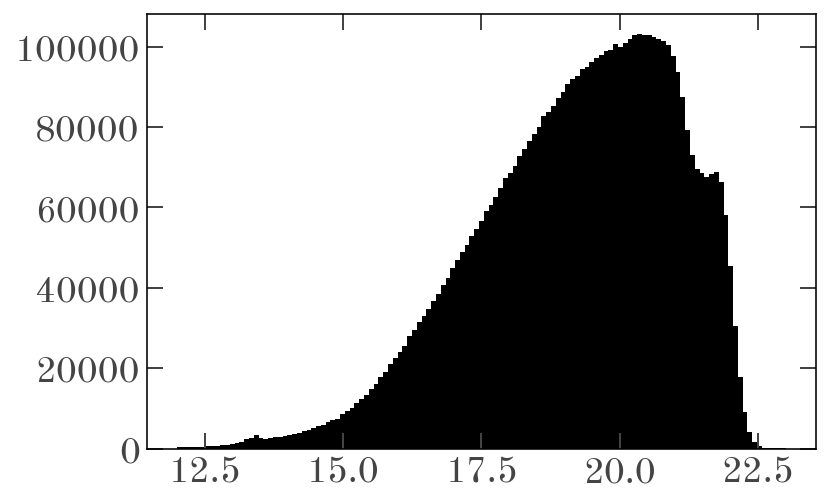

In [29]:
plt.hist(ps1['gMeanPSFMag'], bins=np.linspace(12, 23, 128));

(-5.0, 5.0)

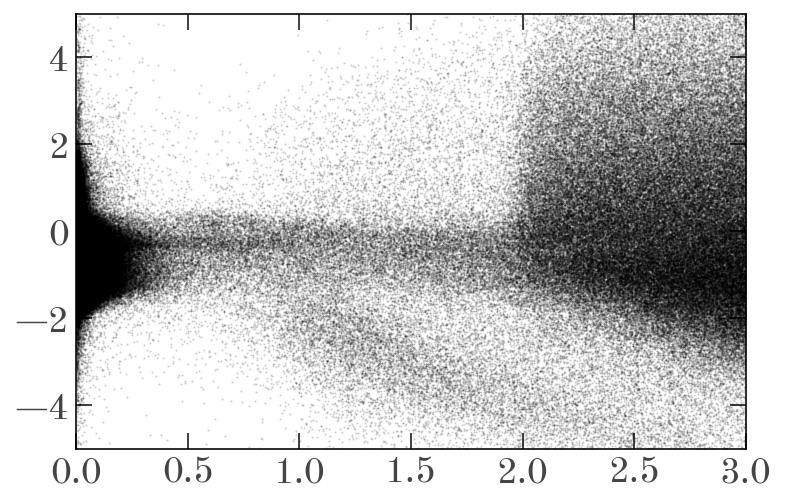

In [50]:
plt.plot(sep.to_value(u.arcsec), 
         (joined['phot_g_mean_mag'] - joined['gMeanPSFMag']),
         marker='o', mew=0, ls='none', ms=1, alpha=0.2)
plt.xlim(0, 3)
plt.ylim(-5, 5)

(-5.0, 5.0)

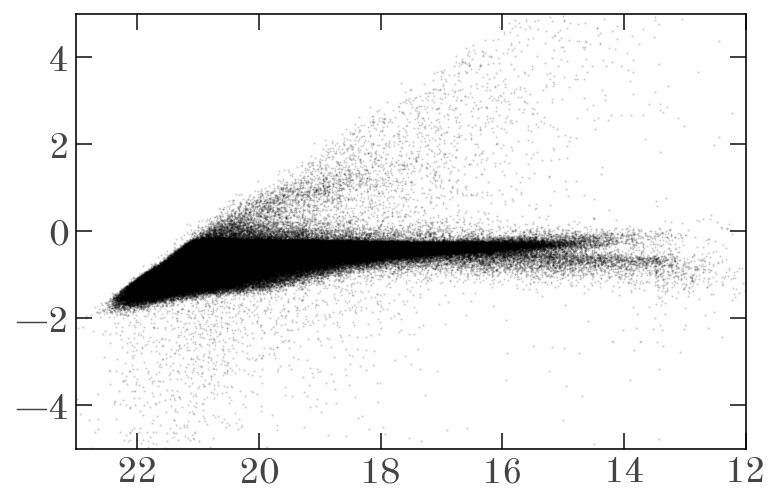

In [30]:
plt.plot(joined['gMeanPSFMag'][dup_mask], 
         (joined['phot_g_mean_mag'] - joined['gMeanPSFMag'])[dup_mask],
         marker='o', mew=0, ls='none', ms=1, alpha=0.2)
plt.xlim(23, 12)
plt.ylim(-5, 5)

(-5.0, 5.0)

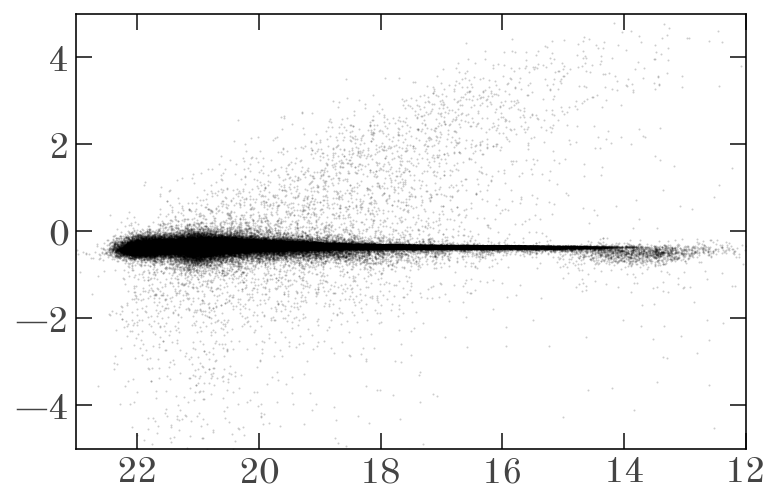

In [31]:
plt.plot(joined['gMeanPSFMag'][dup_mask], 
         (joined['phot_rp_mean_mag'] - joined['iMeanPSFMag'])[dup_mask],
         marker='o', mew=0, ls='none', ms=1, alpha=0.2)
plt.xlim(23, 12)
plt.ylim(-5, 5)

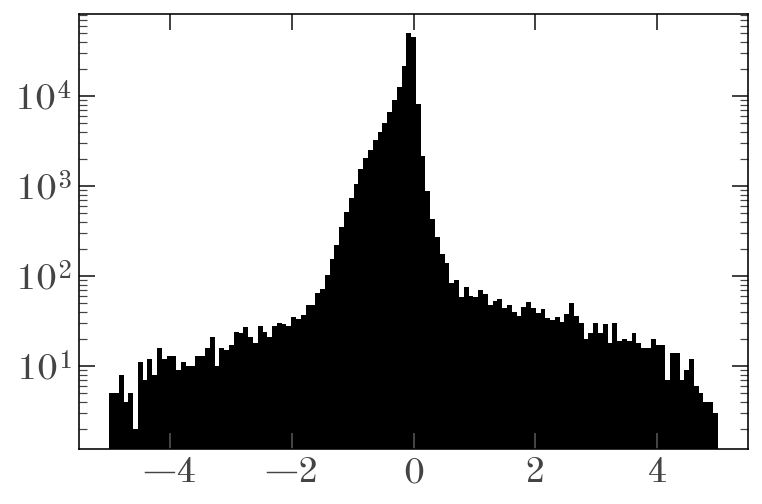

In [32]:
plt.hist((joined['phot_bp_mean_mag'] - joined['gMeanPSFMag'])[dup_mask], 
         bins=np.linspace(-5, 5, 128));
plt.yscale('log')

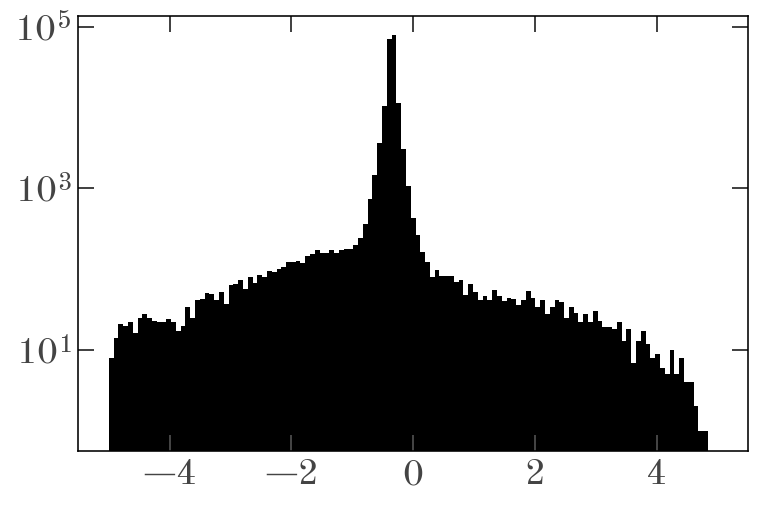

In [33]:
plt.hist((joined['phot_rp_mean_mag'] - joined['iMeanPSFMag'])[dup_mask], 
         bins=np.linspace(-5, 5, 128));
plt.yscale('log')

---